In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import scipy.ndimage.interpolation
import skimage.transform

luna_path = "/mnt/data/luna16/"

# read metadata

from glob import glob

def get_df_node():
    global file_list
    
    df_node = pd.read_csv(luna_path+"original/CSVFILES/annotations.csv")

#     file_list=glob(luna_path+"unpacked/*.mhd")

#     def get_filename(case):
#         global file_list
#         for f in file_list:
#             if case in f:
#                 return(f)

#     df_node["file"] = df_node["seriesuid"].apply(get_filename)
    return df_node

def read_nodes(img_file, df_node, sz=32):
    # img_file = "luna16_unpack/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd"
    itk_img = sitk.ReadImage(img_file)
    img_array = sitk.GetArrayFromImage(itk_img)

    origin = np.array(itk_img.GetOrigin()) #x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())# spacing of voxels in world coor. (mm)

    z_scale = spacing[2]/spacing[1]
    img_iso = scipy.ndimage.interpolation.zoom(img_array, zoom=(z_scale, 1,1), order=1)

    img_nodes = []
    diams = []

    mini_df = df_node[df_node["file"]==img_file]
    for idx in range(len(mini_df)):
        node_x = mini_df["coordX"].values[idx]
        node_y = mini_df["coordY"].values[idx]
        node_z = mini_df["coordZ"].values[idx]
        diam = mini_df["diameter_mm"].values[idx]

        center = np.array([node_x,node_y,node_z])  #nodule center
        v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space
        c = v_center.astype(np.int)

        img_node = img_iso[int(z_scale*c[2]-sz):int(z_scale*c[2]+sz), c[1]-sz:c[1]+sz, c[0]-sz:c[0]+sz]

        img_nodes.append(img_node)
        diams.append(diam / spacing[0])
        # TODO return spacing here as well

    return img_nodes, diams

def get_node_sections(img_node, diam):
    return


In [6]:
def load_scans_luna16(img_file):
    itk_img = sitk.ReadImage(img_file)
    img_array = sitk.GetArrayFromImage(itk_img)

    origin = np.array(itk_img.GetOrigin()) #x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())# spacing of voxels in world coor. (mm)

    return img_array, spacing, origin

def resample_luna16(image, spacing, new_spacing):
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, order=1)
    
    return image, new_spacing



In [10]:
import json

INPUT_FOLDER = '/mnt/data/luna16/unpacked/'
OUTPUT_FOLDER = '/mnt/data/luna16/processed/'

def process_series(pid):
    print(pid)
    # input_file = glob(INPUT_FOLDER+"*/" +pid+  ".mhd")[0]
    image, spacing, origin = load_scans_luna16(INPUT_FOLDER+pid+  ".mhd")
    np.save(OUTPUT_FOLDER + 'original_resolution/' + pid + '.npy', image)

    with open(OUTPUT_FOLDER + 'original_resolution/' + pid + '.info.json', 'w') as f:
        json.dump({'spacing': list(spacing), 'origin':list(origin)}, f)

    image_1mm, _ = resample_luna16(image, spacing, np.asarray([1,1,1]))
    np.save(OUTPUT_FOLDER + '1mm/' + pid + '.npy', image_1mm)

    #     image_iso, _ = resample(image, scans, [spacing[1], spacing[1], spacing[2]])
    #     np.save(OUTPUT_FOLDER + 'iso/' + pid + '.npy', image_iso)

    segmented_lungs_fill = segment_lung_mask(image, True)
    np.save(OUTPUT_FOLDER + 'segmented_lungs/' + pid + '.npy', segmented_lungs_fill)



In [11]:
df_node = get_df_node()
patient_ids = list(set(df_node["seriesuid"]))

In [16]:
for pid in df_node["seriesuid"][3:4]:
    process_series(pid)


1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405


In [15]:
from skimage import measure, morphology

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    binary_image = np.array(image > -320, dtype=np.int8)
    binary_image = scipy.ndimage.morphology.binary_dilation(binary_image, border_value=0, iterations=2).astype(np.int8)
    # HACK deal with trays
    binary_image[-1,:,0] = 0
    binary_image[-1,:,-1] = 0
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image += 1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [23]:
pid = df_node["seriesuid"][3]
image = np.load(OUTPUT_FOLDER + 'original_resolution/' + pid + '.npy')

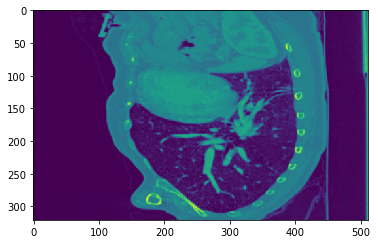

In [26]:
from pylab import *
%matplotlib inline
imshow(image[:,:,356])

In [21]:
image.shape

(179, 285, 512)